In [1]:
import cupy as cp
import numpy as np
import time

%load_ext autoreload
%autoreload 2

In [14]:
### Numpy and CPU
s = time.time()
x_cpu = np.ones((4000,100,1))
e = time.time()
print(e - s)

0.0019998550415039062


In [16]:
### CuPy and GPU
s = time.time()
x_gpu = cp.ones((4000,1))
cp.cuda.Stream.null.synchronize()
e = time.time()
print(e - s)

0.0009999275207519531


In [13]:
import math
from bprH_gpu import bprH, adv_index, save_model, load_model
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
import numpy as np
import cProfile as profile

In [7]:
def behavior_generator(num_user = 10, num_item=10):
    data = []
    for u in range(num_user):
        for i in range(num_item):
            p = np.random.uniform(0,1)
            if 0.7 <= p:
                data.append(['U' + str(u),'I' + str(i),'P'])
                data.append(['U' + str(u),'I' + str(i),'V'])
            elif 0.3 <= p:
                data.append(['U' + str(u),'I' + str(i),'V'])
    data = pd.DataFrame(data, columns=['UserID', 'ItemID', 'Action'])
    return data

In [8]:
data = behavior_generator(num_user=50, num_item=50)

In [9]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [10]:
# split the data_only_with_target into 5 folds
#kf = KFold(n_splits=5,shuffle=True, random_state=0)
#kf.get_n_splits(X=data_only_with_target)

d1, test_data = train_test_split(data_only_with_target, test_size=0.2)

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [12]:
model = bprH(dim=12,
                 omega=10,
                 rho=1,
                 lambda_u=1.5,
                 lambda_v=0.5,
                 lambda_b=0.5,
                 gamma=0.005,
                 random_state=20200704,
                 num_iter=9000)

model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-test.pkl',
              coselection=True,
              plot_metric=True)

D:\OneDrive - The University of Texas at Dallas\UTD MIS PhD YXL180111\2020 Summer\Research\BPR\BPRH\bprH_gpu.py:77: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "auxiliary_target_correlation" failed type inference due to: Untyped global name 'tqdm': cannot determine Numba type of <class 'type'>

File "bprH_gpu.py", line 90:
    def auxiliary_target_correlation(self, X, y=None):
        <source elided>
        alpha_u = dict()
        user_set_bar = tqdm(self.user_list)
        ^

  def auxiliary_target_correlation(self, X, y=None):
D:\OneDrive - The University of Texas at Dallas\UTD MIS PhD YXL180111\2020 Summer\Research\BPR\BPRH\bprH_gpu.py:77: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "auxiliary_target_correlation" failed type inference due to: Untyped global name 'tqdm': cannot determine Numba type of <class 'type'>

File "bprH_gpu.py", line 90:
    def auxiliary_targe

Calculate auxiliary-target correlation


NotDefinedError: Failed in object mode pipeline (step: analyzing bytecode)
[1mVariable '$168.2' is not defined.[0m
Unsupported Python functionality was found in the code Numba was trying to
compile. This error could be due to invalid code, does the code work
without Numba? (To temporarily disable Numba JIT, set the `NUMBA_DISABLE_JIT`
environment variable to non-zero, and then rerun the code).

If the code is valid and the unsupported functionality is important to you
please file a feature request at: https://github.com/numba/numba/issues/new

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html


In [20]:
kf = KFold(n_splits=5,shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    # page 90 5.2 section - make most of auxiliary data in training process
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=8,
                 omega=1,
                 rho=1,
                 lambda_u=1.5,
                 lambda_v=0.1,
                 lambda_b=0.1,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=9000)

    model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl',
              coselection=True,
              plot_metric=True)
    cnt += 1


KeyboardInterrupt: 

In [14]:
# read sobazaar data
data = pd.read_csv('data/sb_unique_actions_20.csv')
# change column name
data.columns = ['ItemID', 'UserID', 'Action', 'Action_Date', 'Action_Time',
       'SessionID']

# data = data.sample(frac=0.5) # TODO: test small data

In [15]:
# the best way is to split the data with a time manner - from sklearn.model_selection import TimeSeriesSplit
# but first let's do it in a simple way

original_item_list = sorted(set(data.ItemID))
original_user_list = sorted(set(data.UserID))

data_without_target = data[data.Action != 'P']
data_only_with_target = data[data.Action == 'P']

In [14]:
# split the data_only_with_target into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(X=data_only_with_target)

5

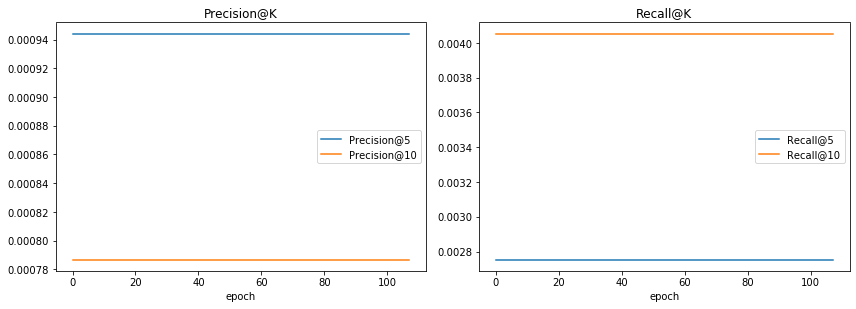

Precision@K
	Precision@5      	 (min:    0.001, max:    0.001, cur:    0.001)
	Precision@10     	 (min:    0.001, max:    0.001, cur:    0.001)
Recall@K
	Recall@5         	 (min:    0.003, max:    0.003, cur:    0.003)
	Recall@10        	 (min:    0.004, max:    0.004, cur:    0.004)


  1%|          | 108/10000 [05:58<8:42:26,  3.17s/it, loss=[-18.54167686], norm_nabula_U_u=13.200473601064267, norm_nabula_Vi=5.99, norm_nabula_Vj=0, norm_nabula_Vk=8.87, precision_10=0.000787, precision_5=0.000944, recall_10=0.00405, recall_5=0.00275]


KeyboardInterrupt: 

In [15]:
cnt = 0
for train_index, test_index in kf.split(X=data_only_with_target):
    # build train and test data
    train_data = pd.concat([data_only_with_target.iloc[train_index], data_without_target])
    test_data = data_only_with_target.iloc[test_index]

    # start a BPRH model
    model = bprH(dim=30,
                 omega=1000,
                 rho=1,
                 lambda_u=1,
                 lambda_v=0.5,
                 lambda_b=0.5,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=10000)

    model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-'+str(cnt)+'.pkl',
              coselection=True,
              plot_metric=True)
    cnt += 1

In [16]:
d1, test_data = train_test_split(data_only_with_target, test_size=0.2)

train_data = pd.concat([d1, data_without_target])
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

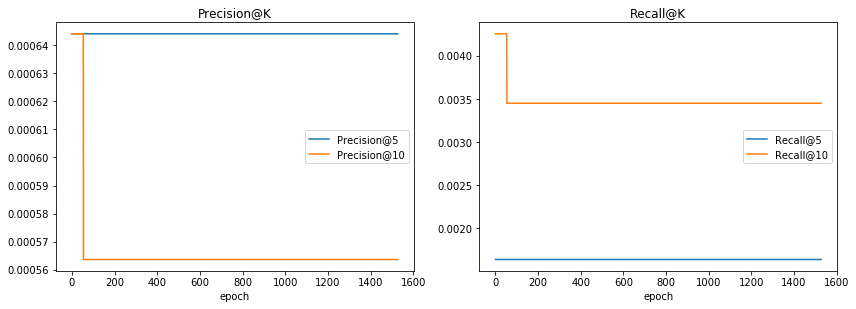

Precision@K
	Precision@5      	 (min:    0.001, max:    0.001, cur:    0.001)
	Precision@10     	 (min:    0.001, max:    0.001, cur:    0.001)
Recall@K
	Recall@5         	 (min:    0.002, max:    0.002, cur:    0.002)
	Recall@10        	 (min:    0.003, max:    0.004, cur:    0.003)


 15%|█▌        | 1528/10000 [1:49:59<9:54:06,  4.21s/it, loss=-18.67486991447922, norm_nabula_U_u=17.392352863708346, norm_nabula_Vi=4.95, norm_nabula_Vj=6.26, norm_nabula_Vk=6.15, precision_10=0.000564, precision_5=0.000644, recall_10=0.00345, recall_5=0.00164]

In [ ]:
pr = profile.Profile()
pr.enable()

model = bprH(dim=30,
                 omega=1000,
                 rho=1,
                 lambda_u=1.5,
                 lambda_v=0.5,
                 lambda_b=0.5,
                 gamma=0.01,
                 random_state=20200704,
                 num_iter=10000)

model.fit(X=train_data,
              eval_X=test_data,
              original_item_list=original_item_list,
              original_user_list=original_user_list,
              saved_path='data/item-set-coselection-test.pkl',
              coselection=True,
              plot_metric=True)

pr.disable()
pr.dump_stats("bhrH_gpu_profile.pstat")